In [98]:
import os
import re
import random
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from scripts.data_cleaning import clean_data


import itertools

In [99]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [101]:
SEED = 1971

In [102]:
# clean data 
train.set_index("id", inplace=True)
test.set_index("id", inplace=True)
cleaned_train_orig = clean_data(train)
cleaned_test_orig = clean_data(test)

In [103]:
# # chnage pass to cat col
# cleaned_test_orig["passport"] = cleaned_test_orig["passport"].astype('object')
# cleaned_train_orig["passport"] = cleaned_train_orig["passport"].astype('object')

In [104]:
# cleaned_train_orig.info()

In [105]:
CAT_COL  = cleaned_test_orig.select_dtypes(include=['object', 'category']).columns
NUM_COL = [col for col in cleaned_test_orig.columns if col not in CAT_COL]
CONT_COl = ["age", "duration_of_pitch", "monthly_income"]

In [106]:

def encode_nan_value(X):
    for col in X.columns:
        if X[col].isna().sum()>0:
            X[f'{col}_is_nan'] = X[col].isna().astype(int)
            col_names.append(f'NA_{col}')
    return X

def fill_na_num(X_train, X_test, num_coulumns):
    for col in num_coulumns:
        if X_train[col].skew() >1:
            X_train[col].fillna(X_train[col].median(), inplace=True)
            X_test[col].fillna(X_train[col].median(), inplace=True)

        else:
            X_train[col].fillna(X_train[col].mean(), inplace=True)
            X_test[col].fillna(X_train[col].mean(), inplace=True)
            
    return X_train, X_test

def binning_cont_col(X_train, X_test, columns): 
    n_bins = int(np.floor(1 + np.log2(len(X_train))))
    for col in columns:
        bins = pd.cut(X_train[col], bins=n_bins, retbins=True)[1]
        # Apply the same bins to the training data
        X_train[f'{col}_binned'] = pd.cut(X_train[col], bins=bins, labels=False, include_lowest=True)
        # Apply the same bins to the test data
        X_test[f'{col}_binned'] = pd.cut(X_test[col], bins=bins, labels=False, include_lowest=True)
        
    return X_train, X_test
def get_group_col(X_train, X_test, y, columns, n_columns=[2]):
    X_train["_target"] = y
    prior = np.mean(y)
    for n in n_columns:
        combinations = list(itertools.combinations(columns, n))
        for comb in combinations:
            comb = list(comb)
            new_cols = comb.copy()
            new_cols.append("_".join(comb) + "_CG")
            print(comb, new_cols)
            new_df = X_train.groupby(comb)["_target"].agg(['mean']).reset_index()
            new_df.columns = new_cols
            X_train = X_train.merge(new_df, on=comb, how='left')
            X_test = X_test.merge(new_df, on=comb, how='left')
    X_test.fillna(prior, inplace=True)
    X_train.drop(columns=["_target"], axis=1, inplace=True)
    return X_train, X_test
    
def create_feature(X_train, X_test, target, cat_columns, num_coulumns, conti_columns ):
    # create encode nan
    X_train = encode_nan_value(X_train)
    X_test = encode_nan_value(X_test)
    
    # # handle missing value 
    # cat column, fill with unknown
    X_train[cat_columns].fillna("unknown", inplace=True)
    X_test[cat_columns].fillna("unknown", inplace=True)
    
    # num colif skew is greater than 1, fill with median else mean 
    X_train, X_test = fill_na_num(X_train, X_test, num_coulumns)
            
    ## binarization of coninious column 
    X_train, X_test = binning_cont_col(X_train, X_test, conti_columns)
    
    

In [107]:
comb = list(combinations[0])

In [108]:
cleaned_train_orig.groupby(comb)["prod_taken"].mean()

typeof_contact   occupation    
Company Invited  Large Business    0.324786
                 Salaried          0.129344
                 Small Business    0.198777
Self Enquiry     Large Business    0.181818
                 Salaried          0.086364
                 Small Business    0.132463
Name: prod_taken, dtype: float64

In [109]:
cleaned_test_orig[NUM_COL].nunique()

age                            53
city_tier                       3
duration_of_pitch              33
number_of_person_visiting       4
number_of_followups            11
preferred_property_star         3
number_of_trips                 8
passport                        2
pitch_satisfaction_score        5
monthly_income               2527
dtype: int64

In [110]:
cleaned_test_orig[NUM_COL].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3489 entries, 3489 to 6977
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3396 non-null   float64
 1   city_tier                  3489 non-null   int64  
 2   duration_of_pitch          3358 non-null   float64
 3   number_of_person_visiting  3489 non-null   float64
 4   number_of_followups        3465 non-null   float64
 5   preferred_property_star    3489 non-null   float64
 6   number_of_trips            3447 non-null   float64
 7   passport                   3489 non-null   int64  
 8   pitch_satisfaction_score   3489 non-null   int64  
 9   monthly_income             3440 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 299.8 KB


In [111]:
cleaned_train_orig[NUM_COL].skew()

age                           2.190105
city_tier                     0.444752
duration_of_pitch             1.263970
number_of_person_visiting    -0.007391
number_of_followups          10.028865
preferred_property_star       1.013766
number_of_trips               0.819289
passport                      2.620316
pitch_satisfaction_score      0.317333
monthly_income                0.815268
dtype: float64

In [112]:
    
def get_corr_plot(corr, title="correlations"):
    fig, ax = plt.subplots(figsize=(10,5))
    plt.title(title, fontsize=14)

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    np.fill_diagonal(mask, False)
    
    # Generate the heatmap including the mask
    heatmap = sns.heatmap(corr,
                        annot=True,
                        annot_kws={"fontsize": 10},
                        fmt='.2f',
                        linewidths=0.5,
                        cmap='RdBu',
                        mask=mask, # the mask has been included here
                        ax=ax)

    # Display our plot
    plt.show()

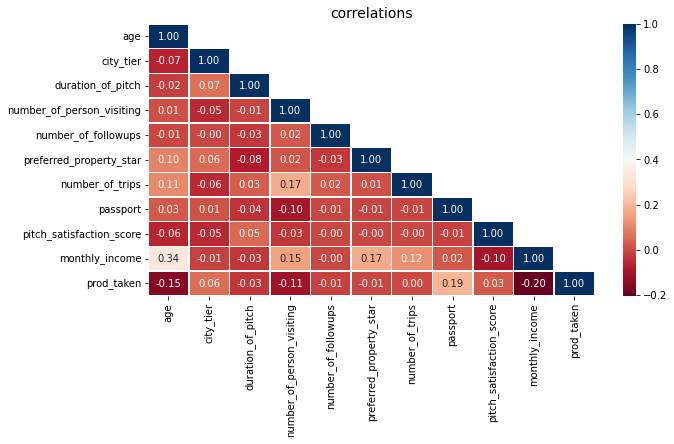

In [113]:
get_corr_plot(cleaned_train_orig.corr())

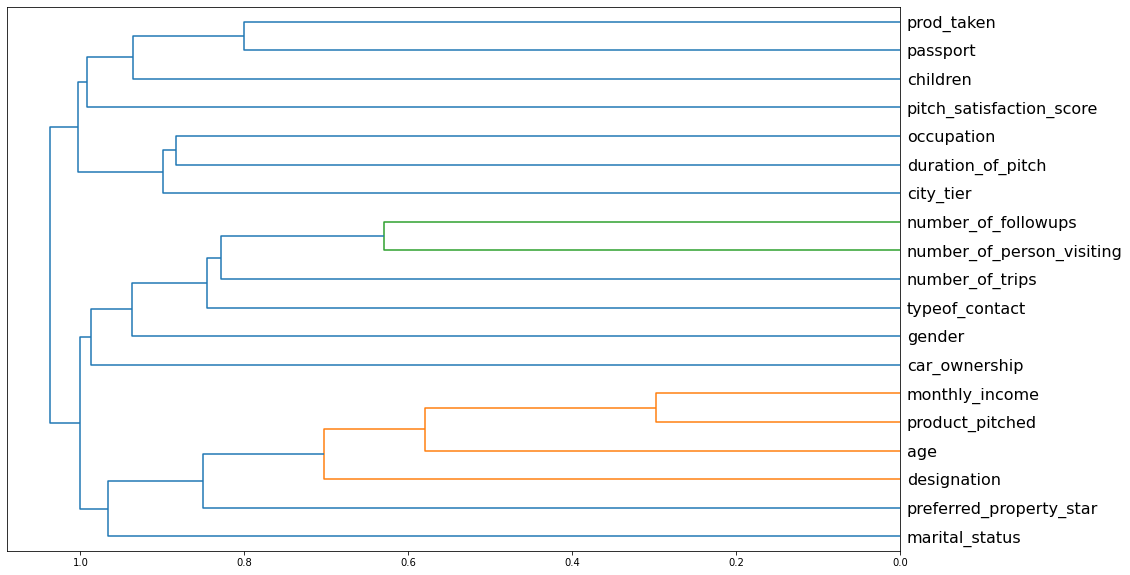

In [114]:
import scipy
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(cleaned_train_orig.dropna()).correlation, 4)
plt.figure(figsize=(16,10))
hc.dendrogram(hc.linkage(hc.distance.squareform(1-corr), 
                         method='average'), 
              labels=cleaned_train_orig.columns, orientation='left', 
              leaf_font_size=16)
plt.show()

In [87]:
cleaned_train_orig.columns[14]

'monthly_income'

array([[ 8.        , 14.        ,  0.2974    ,  2.        ],
       [ 0.        , 19.        ,  0.5798    ,  3.        ],
       [ 6.        ,  7.        ,  0.6293    ,  2.        ],
       [13.        , 20.        ,  0.70233333,  4.        ],
       [11.        , 15.        ,  0.8007    ,  2.        ],
       [10.        , 21.        ,  0.82855   ,  3.        ],
       [ 1.        , 24.        ,  0.846     ,  4.        ],
       [ 9.        , 22.        ,  0.85035   ,  5.        ],
       [ 3.        ,  4.        ,  0.8827    ,  2.        ],
       [ 2.        , 27.        ,  0.89865   ,  3.        ],
       [18.        , 23.        ,  0.9357    ,  3.        ],
       [ 5.        , 25.        ,  0.93655   ,  5.        ],
       [16.        , 26.        ,  0.96664   ,  6.        ],
       [17.        , 30.        ,  0.98668   ,  6.        ],
       [12.        , 29.        ,  0.9913    ,  4.        ],
       [31.        , 32.        ,  1.00016667, 12.        ],
       [28.        , 33.

In [31]:
cleaned_train_orig["prod_taken"].mean()

0.14244769274863858

In [29]:
cleaned_train_orig.groupby("children")["prod_taken"].mean()

children
1 Children     0.114650
2 Children     0.118932
3 Children     0.068493
No Children    0.217259
unknown        0.000000
Name: prod_taken, dtype: float64

In [21]:
cleaned_train_orig.groupby("marital_status")["prod_taken"].mean()

marital_status
Divorced     0.116173
Married      0.098266
Single       0.334365
Unmarried    0.074010
Name: prod_taken, dtype: float64

In [22]:
cleaned_train_orig.groupby("gender")["prod_taken"].mean()

gender
female    0.102456
male      0.170058
Name: prod_taken, dtype: float64

In [74]:
len(CAT_COL)

8

In [73]:
cleaned_train_orig.groupby(["typeof_contact", "children", "gender"])["prod_taken"].mean()

typeof_contact   children     gender
Company Invited  1 Children   female    0.091603
                              male      0.171930
                 2 Children   female    0.113924
                              male      0.224359
                 3 Children   female    0.166667
                              male      0.125000
                 No Children  female    0.180328
                              male      0.291498
                 unknown      female    0.000000
                              male      0.000000
Self Enquiry     1 Children   female    0.085561
                              male      0.116279
                 2 Children   female    0.040201
                              male      0.117949
                 3 Children   female    0.055556
                              male      0.048780
                 No Children  female    0.121622
                              male      0.262963
                 unknown      female    0.000000
                              ma

In [70]:
CAT_COL

Index(['typeof_contact', 'occupation', 'gender', 'product_pitched',
       'designation', 'marital_status', 'car_ownership', 'children'],
      dtype='object')

<Figure size 576x1080 with 0 Axes>

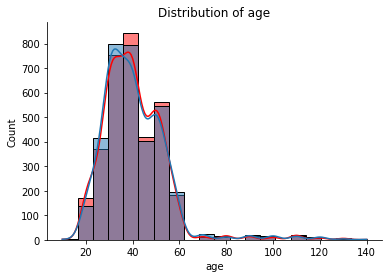

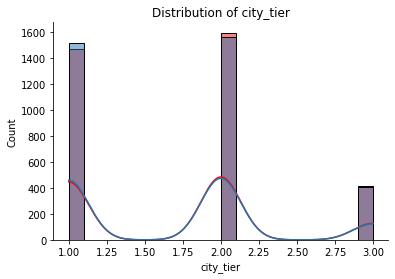

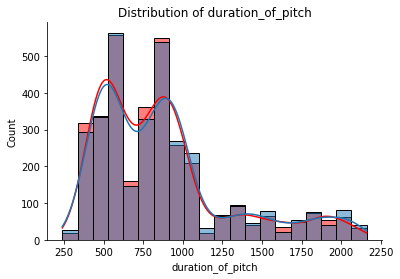

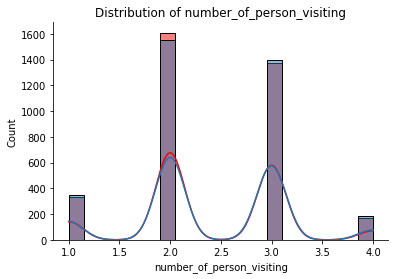

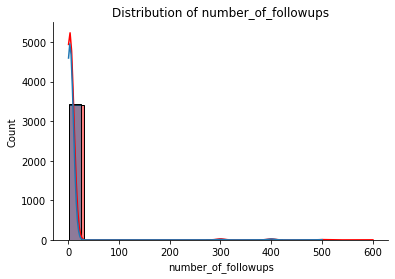

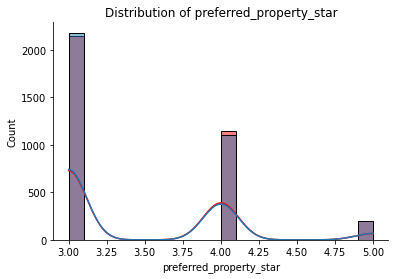

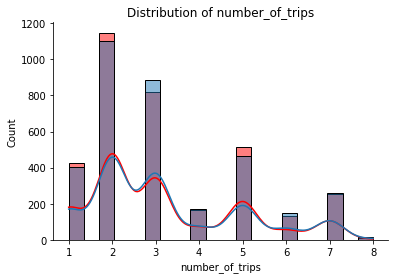

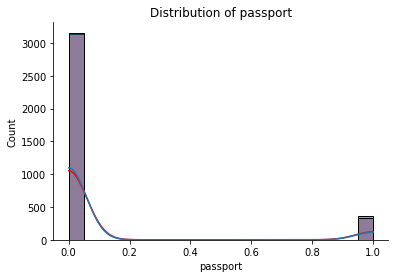

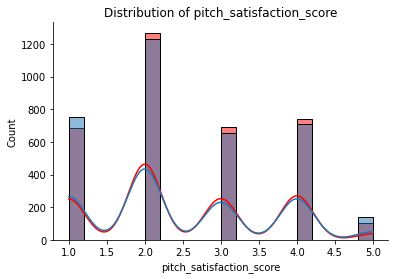

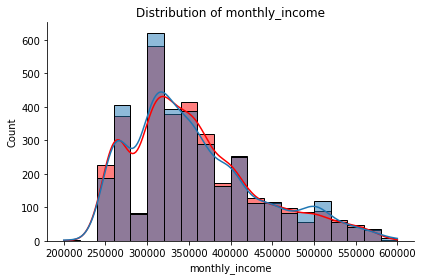

In [10]:
plt.figure(figsize=(8, 15)) 

for i, column in enumerate(NUM_COL):
    plt.subplots()
    sns.histplot(data=cleaned_train_orig, x=column, kde=True, bins=20, color="red", alpha=0.5)
    sns.histplot(data=cleaned_test_orig, x=column, kde=True, bins=20)
    
    plt.title(f'Distribution of {column}')
    sns.despine()

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

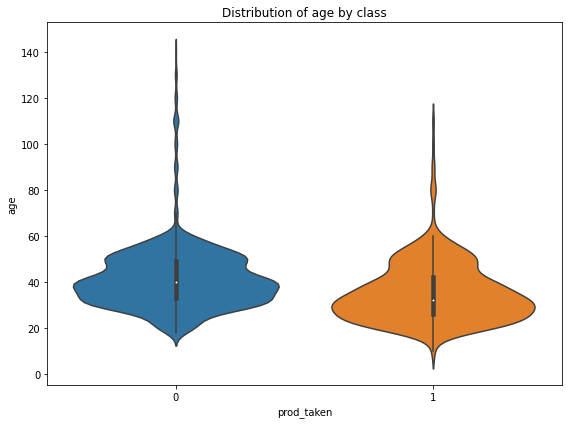

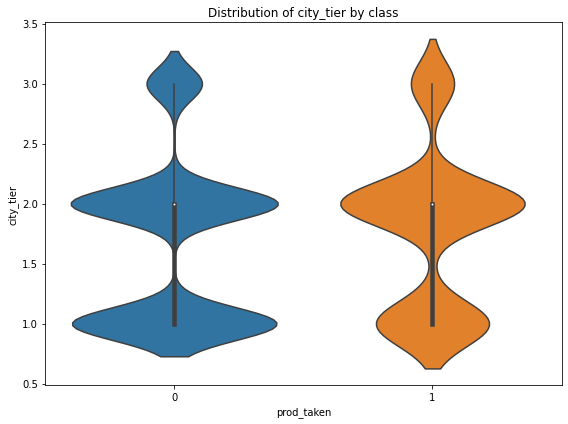

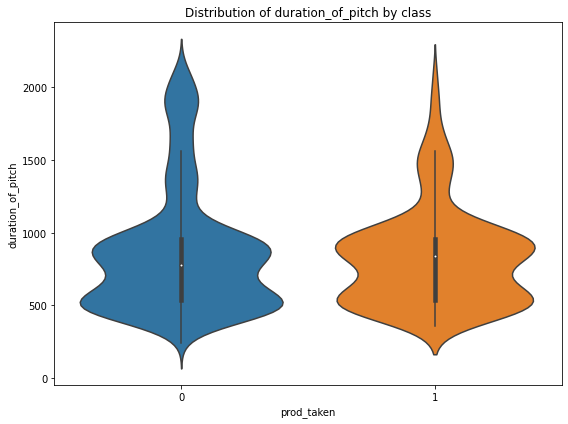

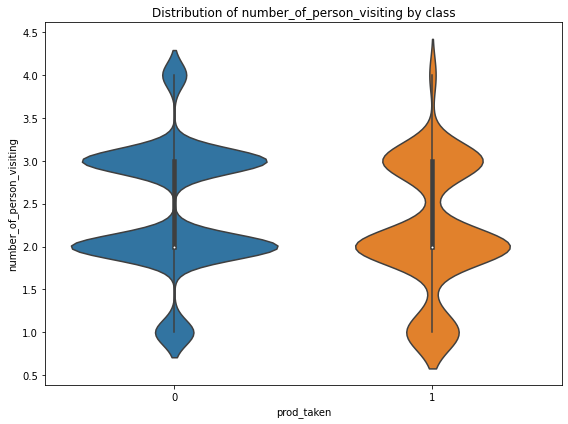

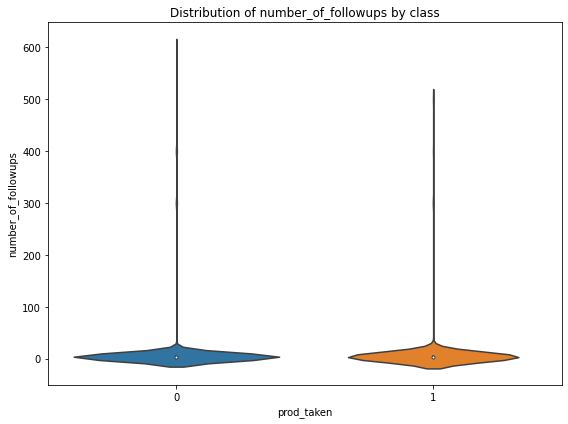

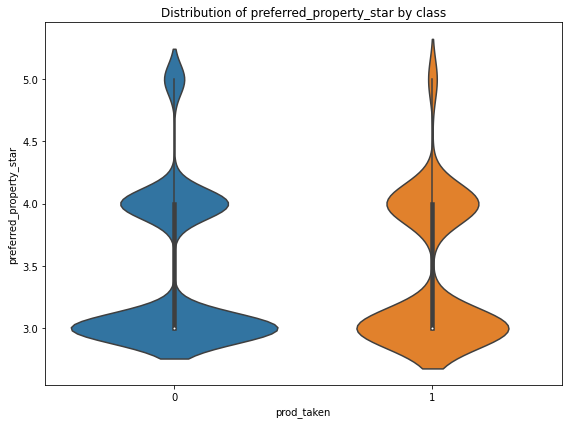

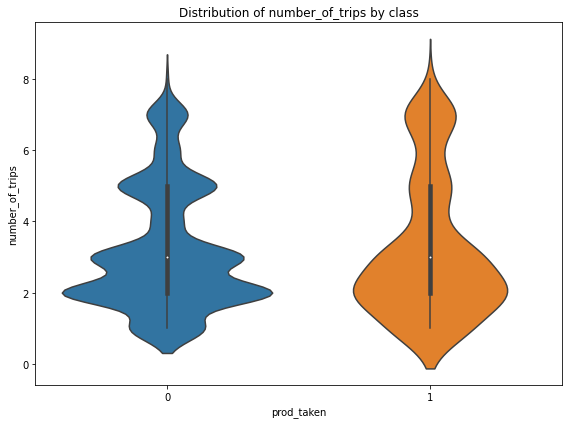

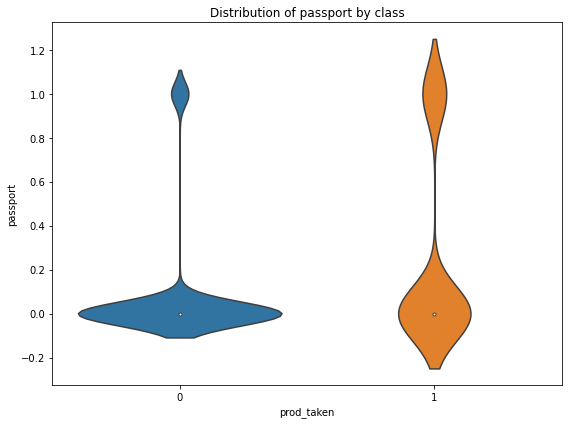

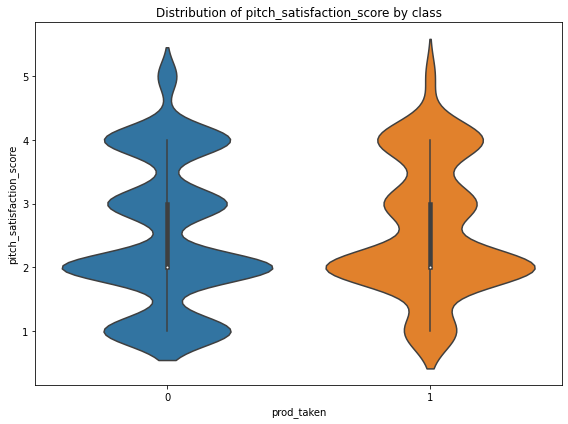

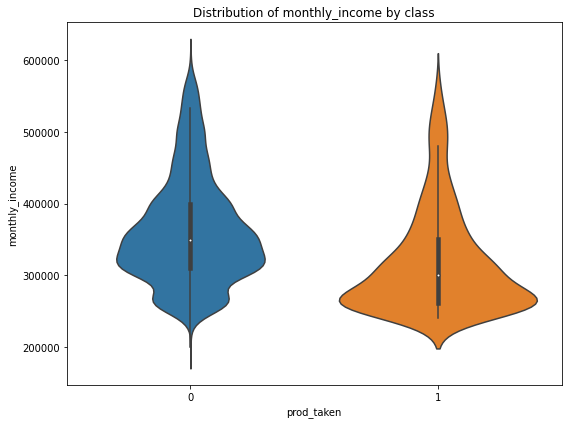

In [11]:
for column in NUM_COL:
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=cleaned_train_orig, x='prod_taken', y=column) 
    plt.title(f'Distribution of {column} by class')

    plt.tight_layout()
    plt.show()

<Figure size 576x432 with 0 Axes>

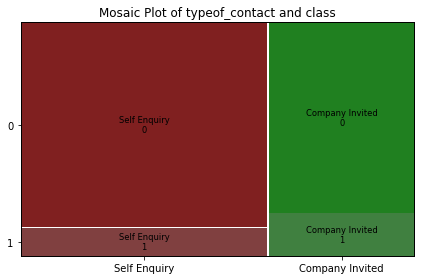

<Figure size 576x432 with 0 Axes>

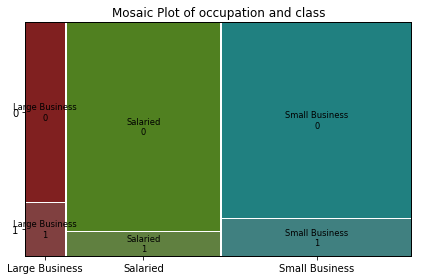

<Figure size 576x432 with 0 Axes>

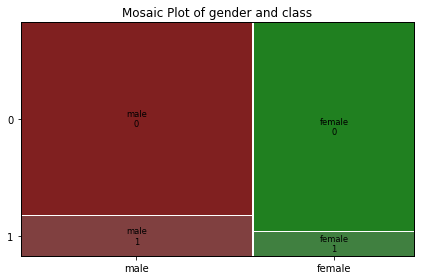

<Figure size 576x432 with 0 Axes>

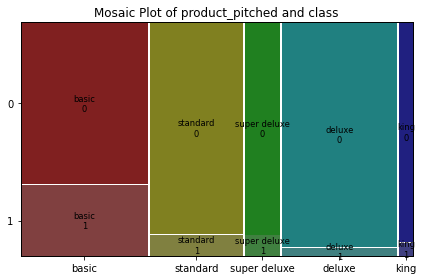

<Figure size 576x432 with 0 Axes>

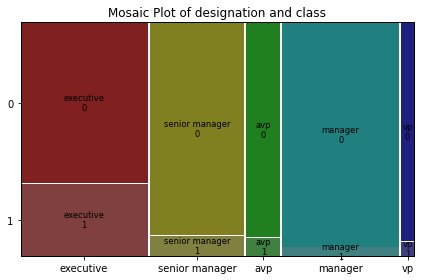

<Figure size 576x432 with 0 Axes>

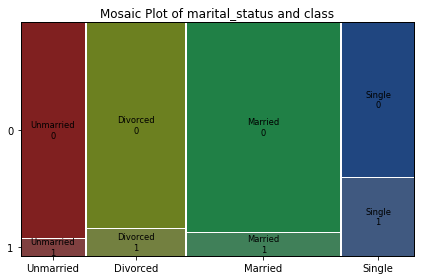

<Figure size 576x432 with 0 Axes>

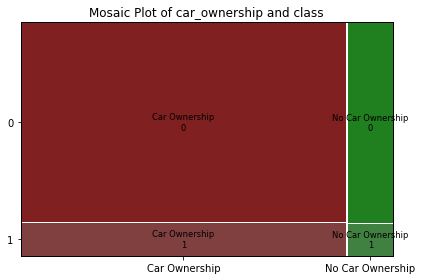

<Figure size 576x432 with 0 Axes>

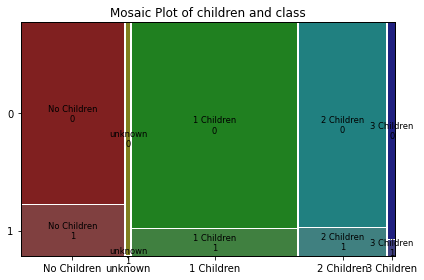

In [13]:
# Plot mosaic plots for each categorical column, excluding "Unknown" values
from statsmodels.graphics.mosaicplot import mosaic
for column in CAT_COL:
    # Exclude "Unknown" values from the DataFrame
    filtered_data = cleaned_train_orig.loc[cleaned_train_orig[column] != 'Unknown']
    
    plt.figure(figsize=(8, 6))
    mosaic(filtered_data, [column, 'prod_taken'])
    plt.title(f'Mosaic Plot of {column} and class')

    plt.tight_layout()
    plt.show()

In [19]:
# Calculate the Z-scores for the numerical columns in the DataFrame
from scipy import stats
z_scores = stats.zscore(cleaned_train_orig[NUM_COL].fillna(cleaned_train_orig[NUM_COL].mean()))

# Generate descriptive statistics for the Z-scores and round the results to 3 decimal places
pd.DataFrame(z_scores, columns=NUM_COL).describe().round(3)

,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,monthly_income
count,3489.000,3489.000,3489.000,3489.000,3489.000,3489.000,3489.000,3489.000,3489.000,3489.000
mean,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.240,-1.038,-1.514,-1.920,-0.172,-0.736,-1.264,-0.338,-1.357,-2.088
25%,-0.627,-1.038,-0.782,-0.543,-0.121,-0.736,-0.687,-0.338,-0.461,-0.741
50%,-0.040,0.451,-0.197,-0.543,-0.096,-0.736,-0.110,-0.338,-0.461,-0.151
75%,0.546,0.451,0.242,0.833,-0.096,0.932,1.045,-0.338,0.436,0.595
max,7.292,1.941,3.170,2.210,15.067,2.600,2.777,2.957,2.229,3.277


In [18]:
cleaned_train_orig[NUM_COL]

,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,passport,pitch_satisfaction_score,monthly_income
id,,,,,,,,,,
0,50.0,2,900.0,1.0,4.0,3.0,5.0,1,4,253905.0
1,56.0,1,840.0,1.0,4.0,3.0,2.0,1,4,404475.0
2,NaN,1,600.0,1.0,3.0,3.0,4.0,0,4,278145.0
3,100.0,2,1080.0,1.0,3.0,4.0,1.0,0,5,326805.0
4,48.0,3,1020.0,1.0,3.0,4.0,4.0,0,4,258435.0
...,...,...,...,...,...,...,...,...,...,...
3484,40.0,2,1560.0,2.0,3.0,3.0,3.0,0,1,258900.0
3485,40.0,1,540.0,3.0,3.0,5.0,5.0,0,3,260415.0
3486,31.0,1,840.0,3.0,2.0,3.0,5.0,0,4,317340.0


In [20]:
cleaned_train_orig[NUM_COL].isna().sum()

age                          100
city_tier                      0
duration_of_pitch            121
number_of_person_visiting      0
number_of_followups           33
preferred_property_star        0
number_of_trips               22
passport                       0
pitch_satisfaction_score       0
monthly_income                56
dtype: int64

In [261]:
cleaned_test_orig[CAT_COL].isna().sum()

typeof_contact     12
occupation          0
gender              0
product_pitched     0
passport            0
designation         0
marital_status      0
car_ownership       0
children            0
dtype: int64

In [262]:
# create new category for type of contact
cleaned_test_orig[CAT_COL].fillna("unknown", inplace = True)
cleaned_train_orig[CAT_COL].fillna("unknown", inplace = True)

In [263]:
target_name = "prod_taken"

In [264]:
# cleaned_train_orig

In [265]:
# data preparation 
train = cleaned_train_orig.drop("prod_taken", axis=1)
y = cleaned_train_orig["prod_taken"]
test = cleaned_test_orig.copy()

In [188]:
# train

In [271]:
def scale(X, scaler=StandardScaler(), train=False):
    X["age_2"] = X["age"]**2
#     X["monthly_income_2"] = X["monthly_income"] **2
    X["monthly_income_log"] = X["monthly_income"].apply(np.log)
    X["age_log"] = X["age"].apply(np.log)
    X["duration_of_pitch_log"] = X["duration_of_pitch"]//60
    X["salary_age"] = X["monthly_income"]/X["age"]

    X["age"] = X["age"]//10.0
    
    col_names = X.columns.tolist()
    if train:
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X = pd.DataFrame(X, columns=col_names)
    # encode nan
    for col in X.columns:
        if X[col].isna().sum()>0:
            X[f'{col}_is_nan'] = X[col].isna().astype(int)
            col_names.append(f'{col}_is_nan')
        
    
    X = X.fillna(0)
    return X, scaler

In [355]:
models = []

In [367]:
import xgboost as xgb
k = 1
f= 1


scores = []
tr_scores = []

skf = StratifiedKFold(n_splits=5, random_state = SEED, shuffle = True)

for train_index, valid_index in skf.split(train, y):
    train_df, valid_df, train_y, valid_y = train.loc[train_index], train.loc[valid_index], y.loc[train_index], y.loc[valid_index]

    train_num = train_df[NUM_COL]
    valid_num = valid_df[NUM_COL]
    
    train_cat = train_df[CAT_COL]
    valid_cat = valid_df[CAT_COL]
    # feature generation 
    # num_col 
    train_num, scaler = scale(train_num, scaler=StandardScaler(), train=True)
    valid_num, _ = scale(valid_num, scaler=scaler, train=False)
    

    te = TargetEncoderCV(CAT_COL, k=3, f=30)
#     te == TargetEncodingExpandingMean(CAT_COL)
    train_cat = te.fit_transform(train_cat, train_y)
    valid_cat = te.transform(valid_cat)

    X_tr = pd.concat([train_cat.reset_index(drop=True), train_num.reset_index(drop=True)], axis=1)
    X_val = pd.concat([valid_cat.reset_index(drop=True, ), valid_num.reset_index(drop=True)], axis=1)

#     model = get_model("xgb")
#     model = LogisticRegression()
#     ratio = float(y.value_counts()[0]) / y.value_counts()[1]
    params = {'n_estimators': 600, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3}
    model = xgb.XGBClassifier(**params)
    

#     print(X_tr.info())
    model.fit(X_tr, train_y)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))

    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))

print(scores)
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))




[0.8198829431438126, 0.8537959866220736, 0.8599686345930085, 0.8156186236319792, 0.8358163575554881]
Train AUC score: 0.8539 Valid AUC score: 0.8370, STD: 0.0177


In [328]:
# Get the coefficients
coefficients = model.coef_[0]

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X_tr.columns,
    'Coefficient': coefficients,
    'Importance': np.abs(coefficients)
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                         Feature  Coefficient  Importance
4                       passport     4.240169    4.240169
5                    designation     3.012384    3.012384
6                 marital_status     3.012032    3.012032
3                product_pitched     2.423381    2.423381
2                         gender     2.275064    2.275064
19            monthly_income_log    -1.238061    1.238061
0                 typeof_contact     1.148862    1.148862
17                monthly_income     0.963245    0.963245
1                     occupation     0.890189    0.890189
26        number_of_trips_is_nan     0.532148    0.532148
25    number_of_followups_is_nan    -0.490554    0.490554
10                     city_tier     0.307799    0.307799
7                  car_ownership    -0.273570    0.273570
20                       age_log    -0.243672    0.243672
27         monthly_income_is_nan    -0.230878    0.230878
29     monthly_income_log_is_nan    -0.230878    0.230878
9             

In [320]:
feature_important = model.get_booster().get_score(importance_type='weight')

In [332]:
xgb_importance= pd.Series(feature_important).sort_values().reset_index() 
xgb_importance.columns =  ["Feature", "xgb"]

In [345]:
imp = pd.merge(xgb_importance, importance_df, on="Feature")
imp.set_index('Feature', inplace=True)

In [346]:
imp = imp - imp.mean()
imp = imp/imp.std()

<AxesSubplot:xlabel='Feature'>

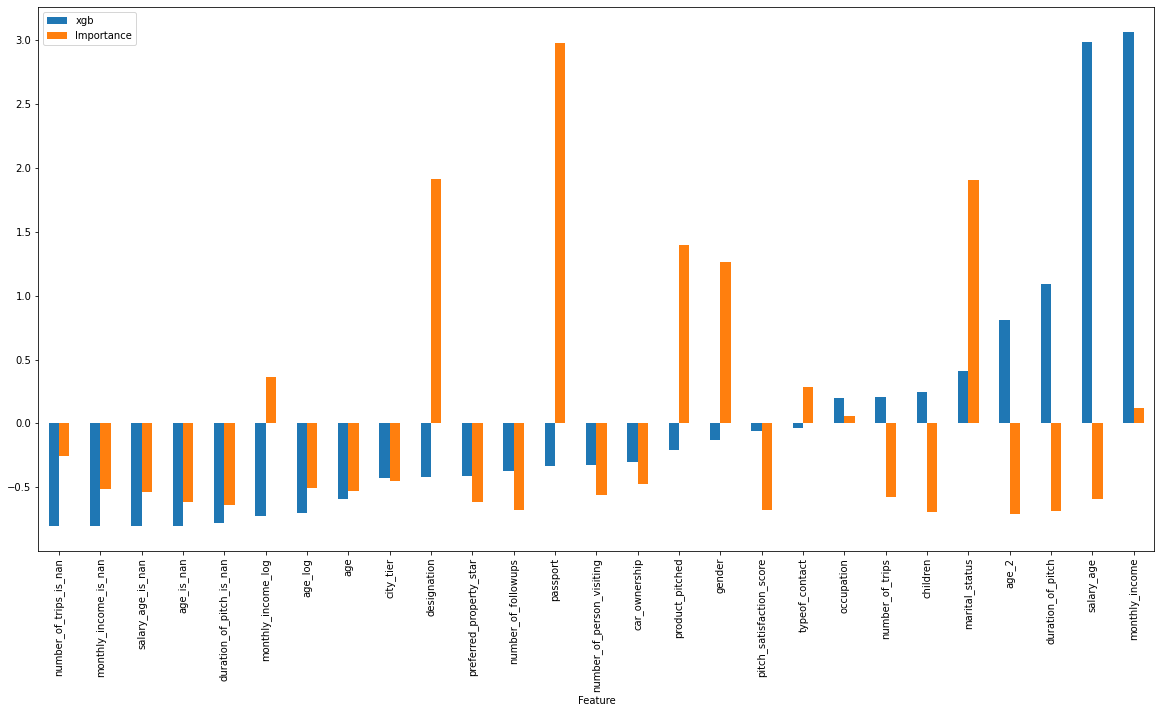

In [353]:
imp[["xgb", "Importance"]].plot(kind="bar", figsize=(20,10))

# create a sumbission file

In [358]:
train_df = train
valid_df = test

predictions = np.zeros(len(valid_df))
train_preds = np.zeros(len(valid_df))

lg = LogisticRegression()
params = {'n_estimators': 600, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3}
xgb = xgb.XGBClassifier(**params)

AttributeError: 'XGBClassifier' object has no attribute 'XGBClassifier'

In [360]:
for model in [xgb, lg]:
    train_num = train_df[NUM_COL]
    valid_num = valid_df[NUM_COL]

    train_cat = train_df[CAT_COL]
    valid_cat = valid_df[CAT_COL]
    # feature generation 
    # num_col 
    train_num, scaler = scale(train_num, scaler=StandardScaler(), train=True)
    valid_num, _ = scale(valid_num, scaler=scaler, train=False)


    te = TargetEncoderCV(CAT_COL, k=3, f=30)
    #     te == TargetEncodingExpandingMean(CAT_COL)
    train_cat = te.fit_transform(train_cat, y)
    valid_cat = te.transform(valid_cat)

    X_tr = pd.concat([train_cat.reset_index(drop=True), train_num.reset_index(drop=True)], axis=1)
    X_val = pd.concat([valid_cat.reset_index(drop=True, ), valid_num.reset_index(drop=True)], axis=1)

    #     model = get_model("xgb")
    #     model = LogisticRegression()
#     params = {'n_estimators': 600, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3}
#     model = xgb.XGBClassifier(**params)

    #     print(X_tr.info())
    model.fit(X_tr, y)

    train_preds +=model.predict_proba(X_tr)[:,1]
    predictions +=model.predict_proba(X_val)[:,1]

    print(roc_auc_score(y, train_preds))

0.8499698054637989
0.8463212429658163


In [361]:
predictions= predictions/2.0

In [362]:
submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [363]:
submit[1] = predictions

In [364]:
submit.to_csv("submission.csv", index=False, header=None)

In [365]:
submit

,0,1
0,3489,0.106830
1,3490,0.236734
2,3491,0.243150
3,3492,0.310578
4,3493,0.378049
...,...,...
3484,6973,0.197182
3485,6974,0.020954
3486,6975,0.543505
3487,6976,0.249329


In [312]:
# df["monthly_income"].plot(kind="hist")

In [313]:
# (train["monthly_income"]/ train["age"]).max()

In [371]:
############# kmeans 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import sklearn
import scipy
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:2], 
                          n_init=1, 
                          max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [381]:
km = KMeansFeaturizer(20)

In [382]:
km_train = km.fit_transform(X_tr[NUM_COL])

AttributeError: 'KMeansFeaturizer' object has no attribute 'km_model'

,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,pitch_satisfaction_score,monthly_income
0,0.926176,0.449462,0.068970,-1.912405,-0.083251,-0.730337,1.017236,1.319758,-1.352753
1,0.926176,-1.049819,-0.072972,-1.912405,-0.083251,-0.730337,-0.696458,1.319758,0.655467
2,4.413787,0.449462,0.494795,-1.912405,-0.112368,0.950703,-1.267690,2.208939,-0.380453
3,0.228654,1.948743,0.352854,-1.912405,-0.112368,0.950703,0.446005,1.319758,-1.292334
4,-1.863913,0.449462,0.210912,-1.912405,-0.112368,-0.730337,-0.696458,1.319758,-1.271461
...,...,...,...,...,...,...,...,...,...
2787,-0.468869,-1.049819,-0.924622,0.845567,-0.083251,-0.730337,1.017236,-0.458603,-0.464679
2788,0.228654,0.449462,1.630329,-0.533419,-0.112368,-0.730337,-0.125227,-1.347784,-1.286133
2789,0.228654,-1.049819,-0.782680,0.845567,-0.112368,2.631743,1.017236,0.430577,-1.265926
2790,-0.468869,-1.049819,-0.072972,0.845567,-0.141485,-0.730337,1.017236,1.319758,-0.506692
